In [1]:
# suppress tensorflow logging, usually not useful unless you are having problems with tensorflow or accessing gpu
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# globally useful libraries / namespaces for this notebook
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# notebook wide settings for plotting visualizations
plt.rcParams['figure.figsize'] = (10, 8) # set default figure size, 10in by 8in

2025-05-23 18:25:27.357218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748024727.374693   24694 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748024727.379693   24694 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748024727.393570   24694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748024727.393600   24694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748024727.393602   24694 computation_placer.cc:177] computation placer alr

# Chapter 2: The Mathematical Building Blocks of Neural Networks

Supporting materials for:

Chollet (2021). *Deep Learning with Python*. 2nd ed. Manning Publications Co.
[Amazon](https://www.amazon.com/Learning-Python-Second-Fran%C3%A7ois-Chollet/dp/1617296864/ref=sr_1_1?crid=32NFM2SBCJVQQ)

Understanding deep learning requires familiarity with many simple mathematical
concepts: tensors, tensor operations, differentiation, gradient descent, and so on.
Out goal in this notebook/chapter is to build up your intiution about these mathematical
concepts without getting over technical.

One note about the term tensors.  **Tensor** is a mathematical term that simply can be used to refer
to a matrix of values, no matter how many dimensions.  Thus a 1-dimensional vector or a 2-dimensional
matrix are both *Tensors*, as well as 3-dimensional or higher matrices.  Vectorized programming
could also be referred to as tensor programming, but the term vectorized programming was coined
before the term tensor was in common use.  Another difference is that the term Tensor programming
and Tensor libraries have come to mean the types of vectorized or tensor operations we usually think of, but
it also includes libraries that can automatically differentiate such tensors with respect to
a loss function.  We will get to these concepts in a bit more detail below.



## Note: Installing Keras/TensorFlow

For this textbook we are using the `TensorFlow` library and mostly accessing the `Keras`
neural network and deep learning API through the `TensorFlow`.  You will need to have
a recent version of `Tensorflow/Keras` installed on your machine and available to your
iPython kernel to run this notebook.  At the time of creation of this notebook, 
`TensorFlow/Keras` is no longer supported directly by the `Conda` package manager.  You
should be doing a `pip install` command of `TensorFlow` to correctly get the 
most recent `TensorFlow` libraries with the `Keras` API available:

```
$ python3 -m pip install 'tensorflow'
```

If you have a suitable Nvidia GPU processor available on your your machine, you can get the `cuda` libraries
setup and installed for `TensorFlow` by doing:

```
python3 -m pip install 'tensorflow[and-cuda]'
```

See the official [Install TensorFlow 2](https://www.tensorflow.org/install) for more detailed information about correctly
getting `TensorFlow/Keras` installed on your system. [Install TensorFlow with pip](https://www.tensorflow.org/install/pip) 
has information on installing cuda/Nvidia.


# 2.3 The Gears of Neural Networks: Tensor Operations

All transformations learned by neural networks can be reduced to a handful of *tensor operations*.
For example, add tensors, multiply tensors, and so on.

The `Dense` or fully connected layer, for example, can be interpreted as a tensor operation that takes
a 2D tensor input and returns another 2D tensor output, using the following tensor operations:

```
output = relu(dot(W, input) + b)
```

There are 3 tensor operations here:  

1. The `dot()` function is the dot product, or a 2D matrix multiplication
   of `W` (the network weights) and the `input`.
2. An addition (+) between the result of the matrix multiplication
   and a vector named `b` (the network biases).
3. A `relu()` operation is done, here `relu(x)` is `max(x, 0)`.  *relu* stands for *rectified linear unit*.

## 2.3.1 Element-wise Operations

The `relu` operation and addition operation of the output above are examples of element-wise operations.  These are operations that are
applied independently to each enatry in the tensors being considered.  These operations are highly amenable to massively parallel implementations,
also known as *vectorized* implementations.  

The dot product above represents a matrix multiplication operation.  But matrix multiplication, and other matrix/tensor operations are also
highly amenable to parallel implementations.

We can write naive implementations of the element-wise operations just discussed.  Naive here means that we are not parallelizing
the computations.  But performing each element-wise operation 1 at a time (using loops to loop over the rank-2 2 dimensional
matrix input).  So a naive `relu()` and `add()` operation would use loops in python over the tensors like this:

In [2]:
def naive_relu(x):
    """Naive (non-vectorized) rectified linear unit activation function.  We expect a 2-D tensor here, and we simply
    loop over each row/column and "rectify" the value (e.g. any negative value becomes 0, but we keep positive values).
    """
    # x is a rank-2 tensor
    assert len(x.shape) == 2
    
    # avoid overwriting the input tensor
    x = x.copy()
    
    # explicit loop to compute relus element by element
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    
    return x

We will later on look at the `relu` and `cross_entropy` activation functions.  For example, all that the
`relu` function does is set negative values to be 0 for the output activation.

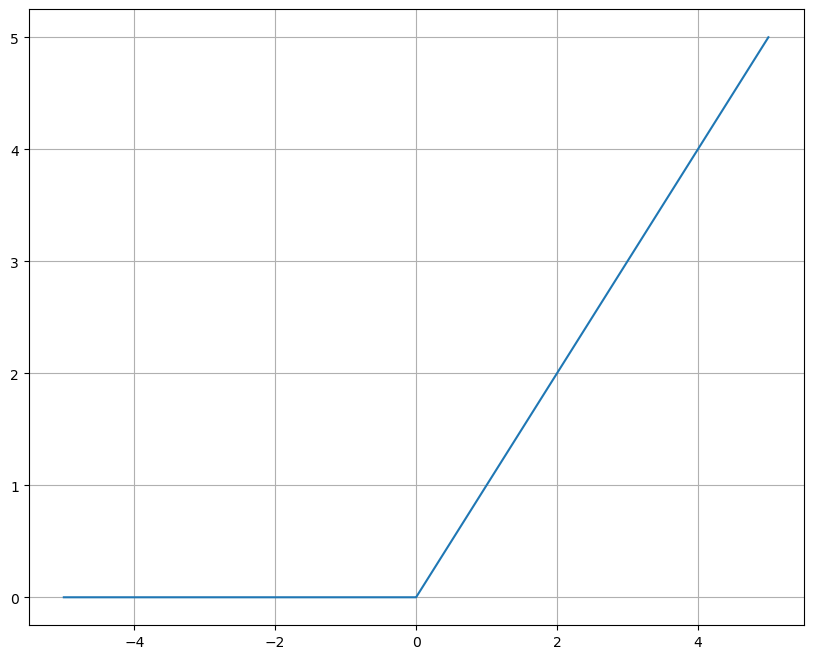

In [3]:
# create a range of input values from -5 to 5
x = np.linspace(-5, 5, 2500)

# we reshape into a (50,50) matrix because that is what our naive_relu function expects
y = naive_relu(x.reshape(50,50))

# visualize the relu function
plt.plot(x.reshape(2500), y.reshape(2500));
plt.grid();

In [4]:
def naive_add(x, y):
    """
    Naive (non-vectorized) matrix + matrix add.  We expect that `x` and `y` are 2-D tensors here of exactly
    the same shapes and sizes.  We loop over each row/column and add corresponding values for the resulting
    element wise addition.
    """
    # x and y are rank-2 tensors
    assert len(x.shape) == 2
    assert x.shape == y.shape
    
    # avoid overwriting the input tensor
    x = x.copy()
    
    # explicit loop to compute element wise addition
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
            
    return x


In [5]:
# example of using naive relu function on some random data
x = np.random.normal(0.0, 3.0, size=(5, 5))
print(x)

x = naive_relu(x)
print(x)

[[-0.52022315  4.64512848 -4.5770441   0.19273057  3.26964759]
 [ 1.74861899 -0.16937206 -0.8116561  -3.50534119 -5.19162492]
 [ 1.24836127  4.82614833  1.18408099 -0.046286   -1.77062902]
 [-2.09672692 -2.87454939  2.46892051 -2.35047757 -0.05608658]
 [-1.00845264  1.12289142  1.62192648 -4.81136952  5.3227735 ]]
[[0.         4.64512848 0.         0.19273057 3.26964759]
 [1.74861899 0.         0.         0.         0.        ]
 [1.24836127 4.82614833 1.18408099 0.         0.        ]
 [0.         0.         2.46892051 0.         0.        ]
 [0.         1.12289142 1.62192648 0.         5.3227735 ]]


In [6]:
# example of using the naive add function on some random data
x = np.random.randint(-5, 5, (5,5))
y = np.random.randint(-5, 5, (5,5))
print(x)
print(y)

z = naive_add(x, y)
print(z)

[[-4 -2  2  2 -5]
 [ 2 -4 -3 -2  2]
 [ 1 -2 -4 -5  4]
 [ 3 -1 -3 -5  0]
 [-2 -3  3  1  1]]
[[-5 -3  1 -1  4]
 [ 2 -4  1 -2  0]
 [ 2 -3 -4  1  1]
 [-5  3  0  2  3]
 [ 1 -4 -1 -1  4]]
[[-9 -5  3  1 -1]
 [ 4 -8 -2 -4  2]
 [ 3 -5 -8 -4  5]
 [-2  2 -3 -3  3]
 [-1 -7  2  0  5]]


In practice, when dealing with tensors represented as NumPy arrays, these operations are available as 
well optimized built-in NumPy functions.  NumPy element-wise and matrix/tensor operations delegate the
heavy lifiting to highly optimized libraries, such as the Basic Linear Algebra Subprograms (BLAS) 
implementation.  BLAS are low-level highly-parallel, efficient tensor-manipulation routines
typically implemented in Fortran or C.

So instead of writing explict serial loops, we can perform element wise operations using vectorized
NumPy routines.  These will be much faster than naive serial implementations.

In [7]:
# generate random data again to demonstrate NumPy vectorized operations
x = np.random.normal(0.0, 3.0, size=(5,5))
y = np.random.normal(0.0, 3.0, size=(5,5))

print(x)
print(y)

[[-1.5210049  -2.36806674  3.19518599 -6.33767599  1.846422  ]
 [ 1.65337041 -1.83024867 -3.19041782  1.23586877 -1.15713514]
 [ 1.30190931  2.419077    2.53269385 -1.76516919  3.78758302]
 [ 1.81935447  2.4011814   3.79351137  2.36171476  3.72502926]
 [-3.488673    2.1474969  -1.20999858 -6.25150233  1.59674593]]
[[ 0.77254344  4.75550948 -1.65835915 -4.16559457  3.17708389]
 [ 0.07302993  4.0407825   0.92388766  4.54144454  6.55951803]
 [-2.87952646 -1.32992947  1.3314314  -0.08250018  4.16373551]
 [-1.91222896 -1.73353634 -1.12028334 -2.32704538  0.71929479]
 [-4.12794895 -2.09525427 -0.09304566 -7.57880226 10.20508481]]


In [8]:
# vectorized elementwise addition
z = x + y

# vectorized numpy function to find max which is relu function
z = np.maximum(z, 0.0)

print(z)

[[ 0.          2.38744274  1.53682684  0.          5.02350588]
 [ 1.72640034  2.21053384  0.          5.77731331  5.40238289]
 [ 0.          1.08914753  3.86412525  0.          7.95131853]
 [ 0.          0.66764506  2.67322803  0.03466938  4.44432405]
 [ 0.          0.05224264  0.          0.         11.80183075]]


Just to drive home the point about efficiency of implementation here, lets compare the time it takes to perform
the same operations using NumPy vectorized operations first:

In [9]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

In [10]:
t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.01 s


Here we are timing performing a vectorized addition and relu, where we perform these operations 1000 times.
The result will usually take only a tenth of a second or less (depending on the cpu of your system) using NumPy vectorized addition and
`maximum` functions.

Compare this to the time it takes to perform the same number of operations using the naive serialized
addition and relu implementations:

In [11]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 1.97 s


Typicaly this will take a whole 1.5 seconds or more to complete, which is a 2 orders of magnitude (> 100) difference in
time needed to perform the same operations.

Likewise, when running TensorFlow code on a GPU, element-wise operations are executed via fully vectorized
CUDA implementations that can best utilize the highly parallel GPU chip architectures.

## 2.3.2 Broadcasting

The previous example of the naive add was hard coded to support addition of rank-2 (2 dimensional) tensors with identical shapes.  But in the
`Dense` layer introduced earlier, we added a rank-2 tensor with a vector.  What happens with addition when the shapes of the two tensors being
added differ?

When possible, if there is no ambiguity, the small tensor will be *broadcast* to match the shape of the larger tensor.  Broadcasting
consists of two steps:

1. Axes (called *broadcast axes*) are added to the smaller tensor to match the `ndim` of the larger tensor.
2. The smaller tensor is repeated alongside these new axes to match the full shape of the larger tensor.

For example, consider `X` with shape `(32, 10)` (32 rows and 10 columns matrix) and `y` with shape `(10,)` (a vector of 10 values):

In [12]:
# X is a 2-d matrix of shape 32, 10.  the random function produces normal random numbers in the range from 0.0 to 1.0
X = np.random.random( (32, 10) )

# y is a random 1-d tensor, or in other words a vector, with shape (10,)
y = np.random.random( (10,) )

If we needed to perform broadcasting by hand, we might do the following.  First we expand the vector into 
a 2-d matrix with 1 row and 10 columns.

In [13]:
y = np.expand_dims(y, axis=0)
y.shape

(1, 10)

Then to match the shape of `X` we can *broadcast* or in other words repeat the values of `y` so that we match the element-wise shape of `X`:

In [14]:
Y = np.concatenate([y] * 32, axis=0)
Y.shape

(32, 10)

In [15]:
# if it is not clear, the following actually repeats the array 32 times
[y] * 32

# then the concatenate function combines them back into a single NumPy
# array, which now has shape (32, 10)

[array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34330405, 0.80837069, 0.52357681, 0.25435843, 0.06758023,
         0.43911618, 0.10272906, 0.59167397, 0.93861909, 0.52335794]]),
 array([[0.34

At this point since `X` and `Y` are the same shape, we can do element-wise operations, such as additon, multiplicaiton, etc.
between the two as before.

In actual implementation of broadcasting by NumPy, no new tensor is created as we did here, the repetition is done
entirely virtually at the algorithmic level to get maximum performance of the operations.

For example, again a naive serialized implementation of adding a matrix and a vector, where we need to broadcast the
vector to the 2-D matrix shape, would look like the following.
Notice there are some constraints on the broadcasting.  The number of elements in the `y` vector has to match the number of columns
of the `X` matrix for the broadcasting to work here.

In [16]:
def naive_add_matrix_and_vector(x, y):
    '''Perform element-wise addition of a matrix and a vector using broadcasting.
    The x matrix is assumed to be a 2-dimensional matrix, and the y vector should have
    the same number of elements as the columns of X for the broadcasting to work.

    Parameters
    ----------
    x - A rank 2 (2-D) matrix of shape (samples, features).
    y - A rank 1 vector.  The number of elements in y must match the number of columns/features of the input x in 
        this naive implementation.
    '''
    # X matrix is assumed to be a rank-2 2-d tensor
    assert len(x.shape) == 2
    
    # y vector is assumed to be a rank-1 vector
    assert len(y.shape) == 1
    
    # broadcasting is only defined if number of elements of vector y matches number of columns of X
    # matrix, so that we broadcast the vector onto each row of X
    assert x.shape[1] == y.shape[0]
    
    # assumptions are met at this point, so we can successfully broadcast the additon
    # make a copy of the X vector to avoid overwriting the input tensor
    x = x.copy()
    
    # perform naive element-wise addition, broadcasting the vector y onto the rows of X
    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            x[row, col] += y[col]
            
    return x

In [17]:
# an example of using our naive broadcasting addition on a vector of 10 values
x = np.random.random( (32, 10) )
y = np.random.random(10)

print(x.shape)
print(y.shape)
print(x)
print(y)

(32, 10)
(10,)
[[4.28616144e-01 6.97802841e-01 5.92880264e-01 8.24706255e-01
  5.53331372e-01 5.73002626e-01 4.33255806e-01 8.71207014e-01
  2.02806014e-01 8.83312889e-01]
 [6.19089233e-01 7.27297902e-01 9.35060247e-01 9.12531181e-01
  5.69274859e-01 5.89630693e-01 6.96267935e-01 7.38010559e-02
  4.69942487e-01 4.47401976e-01]
 [1.57211349e-01 5.06719342e-01 5.96202001e-01 6.50017160e-01
  2.32795900e-01 7.89350834e-01 4.74393265e-01 4.31872999e-03
  9.11852000e-01 7.19040609e-01]
 [6.63237668e-01 1.91620651e-01 7.03117399e-02 7.91121196e-01
  6.97042014e-02 9.49155094e-01 6.26039512e-01 1.03971663e-01
  5.09616118e-01 6.83472069e-01]
 [1.58097992e-01 1.23785463e-01 3.96295097e-01 8.94849085e-01
  8.73774597e-01 1.95373614e-01 4.98307890e-01 8.09725056e-01
  7.39587360e-01 6.99046864e-01]
 [4.13267539e-01 6.20519021e-01 5.00636113e-01 1.22072556e-01
  2.52819032e-02 5.91086946e-01 6.34322977e-01 1.76564816e-01
  3.18575145e-01 8.59904671e-04]
 [6.77794529e-01 3.89186531e-01 1.90988626e

In [18]:
z = naive_add_matrix_and_vector(x, y)
print(z.shape)
print(z)

(32, 10)
[[0.69430511 1.1195818  0.79486474 1.71139486 1.024859   0.60132839
  1.41512709 1.37834994 0.2374904  1.87175126]
 [0.8847782  1.14907686 1.13704473 1.79921978 1.04080249 0.61795646
  1.67813922 0.58094398 0.50462687 1.43584035]
 [0.42290031 0.9284983  0.79818648 1.53670576 0.70432353 0.8176766
  1.45626455 0.51146165 0.94653638 1.70747898]
 [0.92892663 0.61339961 0.27229622 1.6778098  0.54123183 0.97748086
  1.6079108  0.61111459 0.5443005  1.67191044]
 [0.42378695 0.54556442 0.59827958 1.78153768 1.34530223 0.22369938
  1.48017917 1.31686798 0.77427174 1.68748524]
 [0.6789565  1.04229798 0.70262059 1.00876116 0.49680954 0.61941271
  1.61619426 0.68370774 0.35325953 0.98929828]
 [0.94348349 0.81096549 0.39297311 1.6954264  1.13325816 0.88155574
  1.42247    0.72254348 0.84195755 1.22842936]
 [0.71040178 1.21776564 0.24464467 1.35951915 0.61603153 0.65160703
  1.65053025 1.14239047 0.77839196 1.59944117]
 [1.04686072 0.95922217 1.17903381 1.54686266 1.06781307 0.94945878
  1.

Broadcasting will be done automatically by NumPy when using tensors whose shapes
can be broadcast successfully.

Technically, as described in the text, if one tensor has shape `(a, b, ..., n, n+1, ..., m)` and the other has shape
`(n, n+1, ..., m)` then broadcasting should be possible.

For example, adding a rank-4 tensor and a rank-2 tensor, the rank-2 tensor is broadcast appropriately to perform the
operation.

In [19]:
# x is a random rank-4 tensor with shape (64, 3, 32, 10)
x = np.random.random( (64, 3, 32, 10) )
print(x.shape)

# y is a rank-2 tensor of shape (32, 10)
y = np.random.random( (32, 10) )
print(y.shape)

# element-wise maximum function broadcasts y.  result is still shape (64, 3, 32, 10) like x.
# maximum is computed by broadcasting y
z = np.maximum(x, y)
print(z.shape)

(64, 3, 32, 10)
(32, 10)
(64, 3, 32, 10)


In [20]:
# note that dimensions do need to match.  e.g. cannot broadcast even like the following, though you might think
# it would make sense
x = np.random.random( (64, 3, 32, 10) )
y = np.random.random( (320) )

try:
    z = np.maximum(x, y)
    print(z.shape)
except ValueError:
    print('ValueError occurs because operands can not be broadcast together with shapes (64, 3, 32, 10) and (320,)')

ValueError occurs because operands can not be broadcast together with shapes (64, 3, 32, 10) and (320,)


## 2.3.3 Tensor Product

The *tensor product* or *dot product* is one of the most common and most useful tensor operations.

The dot product is also known as the matrix multiplication operation.  This operation is defined over matrices.

In NumPy, you can use the `np.dot()` function to perform the tensor product.  For example, a vector multiplcation
can be done as:

In [21]:
# two vectors each with 32 elements
x = np.random.random( (32,) )
y = np.random.random( (32,) )

# dot product, results in scalar value, because result is computed as if 
# multiplying a 1x32 column matrix times a 32x1 row matrix giving a 1x1 or scalar result
# when performing tensor product of vectors this is known as the inner product
z = np.dot(x, y)
z

8.190792538024649

Since NumPy versions for Python 3, the `@` operator has been defined by NumPy to perform a dot product

In [22]:
# operator @ performs dot product on NumPy arrays
z = x @ y
z

8.190792538024649

A tensor product is a combination of multiplication and summation of groups of elements.  Conceptually for rank-2 and higher tensor products you
can think of it as a weighted sum, as we will see later.

Mathematically for vectors, the dot product (called inner product when both tensors are vectors) is computed as follows:

In [23]:
def naive_vector_dot(x, y):
    """Perform (a naive implementation of the) dot product between two vectors x and y of the same size.
    The dot product of vectors is also known as the inner product, and the result is to multiply each
    corresponding element of x and y and sum up these multiplications, the results is a scalar value.

    Parameters
    ----------
    x, y - rank-1 vectors, both must have the same number of elements for the dot/inner produect to be defined.

    Returns
    -------
    scalar - A dot product of two vectors results in a single scalar result, which is the sum of the product of the
       corresponding elements of x and y.
    """
    # x and y are NumPy vectors
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    
    # x and y vectors have to have equal number of elements
    # for inner product to be defined
    assert x.shape[0] == y.shape[0]
    
    # result of inner product is a scalar.  The inner product is the sum of the element
    # wise multiplications
    z = 0.0
    
    for i in range(x.shape[0]):
        z += x[i] * y[i]
        
    return z

In [24]:
# demonstrate we get the same inner product result using our
# naive serialized implementation of the inner product
z = naive_vector_dot(x, y)
z

8.190792538024649

The dot product, or inner product, of two vectors is a scalar, because we are multiplying each corresponding
element, and adding the result of the multiplications into a single result.

You can take the dot product between a matrix and a vector.  The number of elements of the vector `y` needs to match
the columns (or last dimension) of the matrix `X`.  The result of matrix `@` vector product is a vector where
the coefficients are the dot products between vector `y` and each row of `X`.

An implementation of matrix `@` vector multplication can be done by hand as follows:

In [25]:
def naive_matrix_vector_dot(x, y):
    '''Perform (naive implementation of ) matrix @ vector dot product.  x is constrained to be a
    rank-2 2-d matrix, but it can be of higher rank for general matrix/vector
    multiplication.  Here y is a vector whose number of elements matches the
    number of columns of the 2-d matrix x.  The result is a new vector which is
    the inner product of y with each row of x.

    Parameters
    ----------
    x - a rank-2 matrix of size (samples, features)
    y - a rank-1 vector that must be of size (features, ) for the dot product to be defined

    Returns
    -------
    vector - a vector of size (samples, ) is returned, conceptually this is the result of performing the
      inner product of each sample/row of x with the vector y.
    '''
    # X is a rank-2 matrix
    assert len(x.shape) == 2
    
    # y is a vector
    assert len(y.shape) == 1
    
    # number of columns of X must be same as number of elemnts of the y vector
    assert x.shape[1] == y.shape[0]
    
    # perform the matrix @ vector multiplication.  Result is a vector with same
    # number of elements as rows of X (typo in textbook)
    z = np.zeros(x.shape[0])
    
    # perform the matrix vector product
    for row in range(x.shape[0]):
        for col in range(x.shape[1]):
            z[row] += x[row, col] * y[col]
            
    return z            

In [26]:
# example of using our naive function
x = np.random.random( (5, 10) )
y = np.random.random( (10,) )

z = naive_matrix_vector_dot(x, y)
print(z.shape)
print(z)

(5,)
[4.00026333 2.93318236 2.88470877 4.17970113 2.11302856]


In [27]:
# demonstrate that our naive function is performing the same tensor product
z = x @ y
print(z.shape)
print(z)

(5,)
[4.00026333 2.93318236 2.88470877 4.17970113 2.11302856]


We could have reused our first function for performing the inner product of 2 vectors.  The following is eqivalent and emphasizes
that we are returning the inner product of y with each row of x.

In [28]:
def naive_matrix_vector_dot_2(x, y):
    '''Perform (naive implementation of ) matrix @ vector dot product.  x is constrained to be a
    rank-2 2-d matrix, but it can be of higher rank for general matrix/vector
    multiplication.  Here y is a vector whose number of elements matches the
    number of columns of the 2-d matrix x.  The result is a new vector which is
    the inner product of y with each row of x.

    This version explicitly demonstrates that the resulting vector is the inner product of y with
    each row of x.

    Parameters
    ----------
    x - a rank-2 matrix of size (samples, features)
    y - a rank-1 vector that must be of size (features, ) for the dot product to be defined

    Returns
    -------
    vector - a vector of size (samples, ) is returned, conceptually this is the result of performing the
      inner product of each sample/row of x with the vector y.
    '''
    z = np.zeros(x.shape[0])
    for row in range(x.shape[0]):
        z[row] = naive_vector_dot(x[row, :], y)
    return z

In [29]:
# demonstrate this second version is equivalent to previous and the NumPy tensor product
z = naive_matrix_vector_dot_2(x, y)
print(z.shape)
print(z)

(5,)
[4.00026333 2.93318236 2.88470877 4.17970113 2.11302856]


The dot product generalizes to tensors with an arbitray number of axes.
You can take the dot product of two rank-2 matrices `X` and `Y` if and only if
the shape of `X.shape[1] == Y.shape[0]`, or in other words if the number of columns
of `X` equals the number of rows of `Y`.  The result of the dot product is a
new rank-2 matrix of shape `(X.shape[0], Y.shape[1])`.

Or for example, if `X` is shape `(32, 10)` and `Y` is shape `(10, 22)` then
the dot product of these two matrices is defined since the number of columns of
`X` matches the number of rows in `Y`.  And the resulting size of the dot
product will be a new matrix of shape `(32, 22)`.

Here is a naive implementation of the tensor product operation for rank-2 matrices.
Each resulting element of the tensor product is a sum of the products of a row of 
`X` with a column of `Y`.

In [30]:
def naive_matrix_dot(x, y):
    # X and Y are rank-2 NumPy matrices
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    
    # tensor product is defined if number of columns of x matches
    # number of rows of y
    assert x.shape[1] == y.shape[0]
    
    # result is the sum of the products of each row of x with each column of y,
    # or in other words the inner product of rows of x with coluns of y
    z = np.zeros( (x.shape[0], y.shape[1]) )
    
    # perform the tensor product, iterate over the rows of x
    # and over the columns of y
    for row in range(X.shape[0]):
        for col in range(Y.shape[1]):
            # notice using NumPy slicing to slice out the row and column
            row_x = x[row, :]
            column_y = y[:, col]
            
            # reuse the inner product function from before, compute the scalar inner
            # product of the current row/column
            z[row, col] = naive_vector_dot(row_x, column_y)
            
    return z

In [31]:
# example of tensor product using our naive implementation
# X is shape (3, 10) and Y is shape (10, 2)
X = np.random.random( (3, 10) )
Y = np.random.random( (10, 2) )

# result is a (3, 2) shaped matrix
Z = naive_matrix_dot(X, Y)
print(Z.shape)
print(Z)

(3, 2)
[[2.10553756 2.59926773]
 [2.74341179 2.96945453]
 [1.65412823 1.95221383]]


In [32]:
# just to confirm, the NumPy tensor product should give the same result
Z = X @ Y
print(Z.shape)
print(Z)

(3, 2)
[[2.10553756 2.59926773]
 [2.74341179 2.96945453]
 [1.65412823 1.95221383]]


More generally, you can take the dot product between higher-dimensional tensors.
For example, the resulting shape of tensor product between tensors of shapes is:

- `(a, b, c, d) @ (d,) -> (a, b, c)`
- `(a, b, c, d) @ (d, e) -> (a, b, c, e)`

In [33]:
# example multiplication of a rank-4 tensor and a vector
X = np.random.random( (5, 3, 8, 7) )
y = np.random.random( (7,) )
Z = X @ y
print(X.shape)
print(y.shape)
print(Z.shape)

(5, 3, 8, 7)
(7,)
(5, 3, 8)


In [34]:
# example multiplication of a rank-4 tensor and a rank-2 tensor
X = np.random.random( (5, 3, 8, 7) )
Y = np.random.random( (7, 5) )
Z = X @ Y
print(X.shape)
print(Y.shape)
print(Z.shape)

(5, 3, 8, 7)
(7, 5)
(5, 3, 8, 5)


## 2.3.4 Tensor Reshaping

It is often necessary to reshape tensors.  In general you can always reshape a tensor into a new tensor, with different or same ranks, as long
as the number of resulting elements remains the same in the reshaped tensor.

For example, we did this in the previous dense neural network example for the MNIST data.  The MNIST images contain 28 rows by 28 columns
of pixel inputs, but we feed in the inputs to the nerual networks as a flat `28 * 28 = 784` set of inputs.  So the input layer of the
neural network we trained expected 784 inputs.  So previously we needed to reshape the training images, as follows:

In [35]:
# refetch so we have the original unshaped data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# originally the training images is a set of 60000 samples, where each sample is a 28x28 matrix of image pixels.  Thus the input
# tensor is a rank-3 tensor of shape (60000, 28, 20)
print(train_images.shape)

(60000, 28, 28)


In [36]:
# but our simple Dense neural network expects a simple vector of inputs, so we have to flatten the 2-d
# image into a single dimension of size 784 in order to use these images as input for the network
train_images = train_images.reshape( (60000, 28 * 28) )
print(train_images.shape)

(60000, 784)


Reshaping simply rearranges the rows and columns to match the target shape.  Notice we reduced the tensor from a rank-3 to a rank-2
tensor in this example.  As long as the total number of elements remains the same, we can reshape a matrix to a new one of any rank
and number of elements per rank as desired.  For example, the number of elements in these tensors befor and after reshaping 
was `60000 * 28 * 28`

In [37]:
print(train_images.size)
print(60000 * 28 * 28)

47040000
47040000


Reshaping a tensor means rearranging its rows and columns to match a target shape.  Naturally the reshaped tensor has to have the same total
number of elements as the initial tensor as we discussed.  Some more examples of reshaping a tensor with 6 elements from our textbook:

In [38]:
# vector of elements from 0 to 6
x = np.arange(6)
print(x)
print(x.shape)

[0 1 2 3 4 5]
(6,)


In [39]:
# reshape to (3,2) rank-2 as shown initially in textbook
x = x.reshape( (3, 2) )
print(x)
print(x.shape)

[[0 1]
 [2 3]
 [4 5]]
(3, 2)


In [40]:
# turn into a column matrix, e.g. not a rank-1 vector, but a rank-2 matrix with 6 rows and 1 column
x = x.reshape( (6, 1) )
print(x)
print(x.shape)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
(6, 1)


In [41]:
# turn into (2, 3) shaped matrix
x = x.reshape( (2, 3) )
print(x)
print(x.shape)

[[0 1 2]
 [3 4 5]]
(2, 3)


A special case of reshaping is *transposition* of the rows and columns.  This does change the order
of the elements.  Transposition means to exchange the rows and columns so that `x[i, :]` becomse
`x[:, i]`

In [42]:
# notice that this result is now (3, 2) shaped, and the order of elements is different from original (3, 2) shaped array from the
# transpose operation
x.transpose()

array([[0, 3],
       [1, 4],
       [2, 5]])

## 2.3.5 Geometric Interpretation of Tensor Operations

Tensor operations have a geometric interpretation that can be useful in some cases to get a better understanding of what function the
tensor operations is performing.

For example, consider addition of a vector.  Use a vector `A` with 2 elements, which can be interpreted as a point in
a 2 dimensional geometric space. (notice this is where the confusion between 1-D tensor and 2-D comes from because 
the vector is a rank-1 tensor with 2 elements, that can be though of as points in a 2 dimensional space).

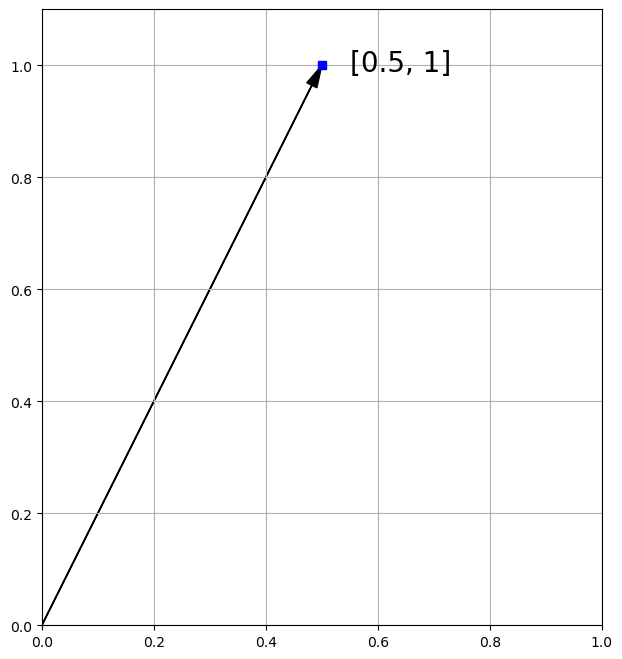

In [43]:
# the vector in 2D space
A = np.array([0.5, 1])

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)

# visualize the vector as direction and magnitude from origin
plt.plot(A[0], A[1], 'bs')
plt.arrow(0, 0, A[0], A[1], head_width=0.02, head_length=0.04, length_includes_head=True, color='black')
plt.text(A[0] + 0.05, A[1] - 0.01, '[0.5, 1]', size=20)

plt.grid();


Now consider a new point `B = [1, 0.25]`.  Vector addition
can be conceptualized geometrically by
chaining together the vector arrows.  The result of vector
element-wise addition is a new vector of a particular direction
and magnitude.

[1.5  1.25]


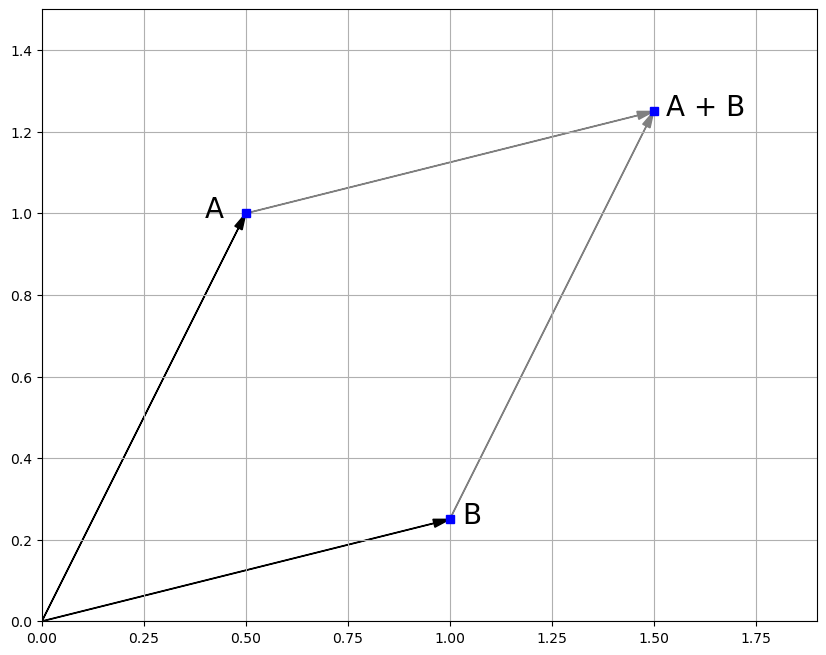

In [44]:
# the vector in 2D space
A = np.array([0.5, 1])
B = np.array([1.0, 0.25])

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(0, 1.9)
ax.set_ylim(0, 1.5)

# visualize the vector as direction and magnitude from origin
plt.plot(A[0], A[1], 'bs')
plt.arrow(0, 0, A[0], A[1], head_width=0.02, head_length=0.04, length_includes_head=True, color='black')
plt.text(A[0] - 0.1, A[1] - 0.01, 'A', size=20)

plt.plot(B[0], B[1], 'bs')
plt.arrow(0, 0, B[0], B[1], head_width=0.02, head_length=0.04, length_includes_head=True, color='black')
plt.text(B[0] + 0.03, B[1] - 0.01, 'B', size=20)

# add vectors, I will call it C
C = A + B
plt.plot(C[0], C[1], 'bs')
plt.arrow(A[0], A[1], B[0], B[1], head_width=0.02, head_length=0.04, length_includes_head=True, color='grey')
plt.arrow(B[0], B[1], A[0], A[1], head_width=0.02, head_length=0.04, length_includes_head=True, color='grey')
plt.text(C[0] + 0.03, C[1] - 0.01, 'A + B', size=20)


plt.grid();
print(C)

Tensor addition thus represents the action of *translating an object* (moving the
object without distorting it) by a certain amount in a certain direction.

For example, if we want to translate a polygon shape, we can do the following.

[[0.  0.4 0.7 0.2 0. ]
 [0.  0.1 0.6 0.5 0. ]]
(2, 5)


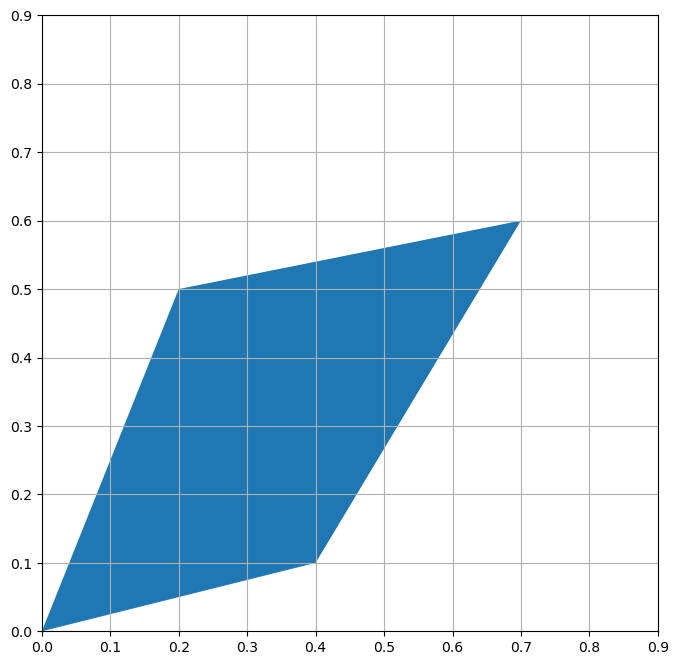

In [45]:
# a shape
x = np.array([0.0, 0.4, 0.7, 0.2, 0.0])
y = np.array([0.0, 0.1, 0.6, 0.5, 0.0])

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)

# represent shape as a 2 row matrix, where each column is
# an x,y point of the shape to fill
s = np.array([x, y])
print(s)
print(s.shape)

# plot filled shape, row 0 are x positions and row 1
# are y positions
plt.fill(s[0], s[1]);
plt.grid();

[[0.2 0.6 0.9 0.4 0.2]
 [0.3 0.4 0.9 0.8 0.3]]
(2, 5)


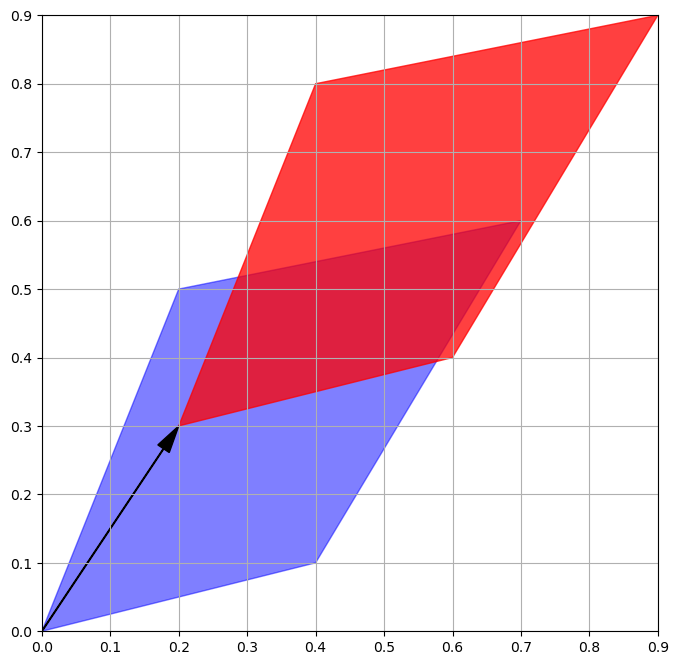

In [46]:
# perform object translation by adding horizontal and vertical factor to shape
# needs to be a (2,1) column matrix for the broadcasting to work here
translation_factors = np.array([0.2, 0.3]).reshape(2,1)

# notice we use broadcasting to add translation factors to shape coordinates
news = translation_factors + s
print(news)
print(news.shape)

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)

# visualize the translation
# plot filled shape, row 0 are x positions and row 1
# are y positions
plt.fill(s[0], s[1], color='blue', alpha=0.5)
plt.fill(news[0], news[1], color='red', alpha=0.75)
plt.arrow(0, 0, translation_factors[0,0], translation_factors[1,0], head_width=0.02, head_length=0.04, length_includes_head=True, color='black')
plt.grid();

Rotation can be achieved by performing tensor product of matrix of `sin` and `cos` of desired rotation.

[[ 0.          0.33128347  0.41710561 -0.00656581  0.        ]
 [ 0.          0.24546133  0.82220612  0.53847645  0.        ]]
(2, 5)


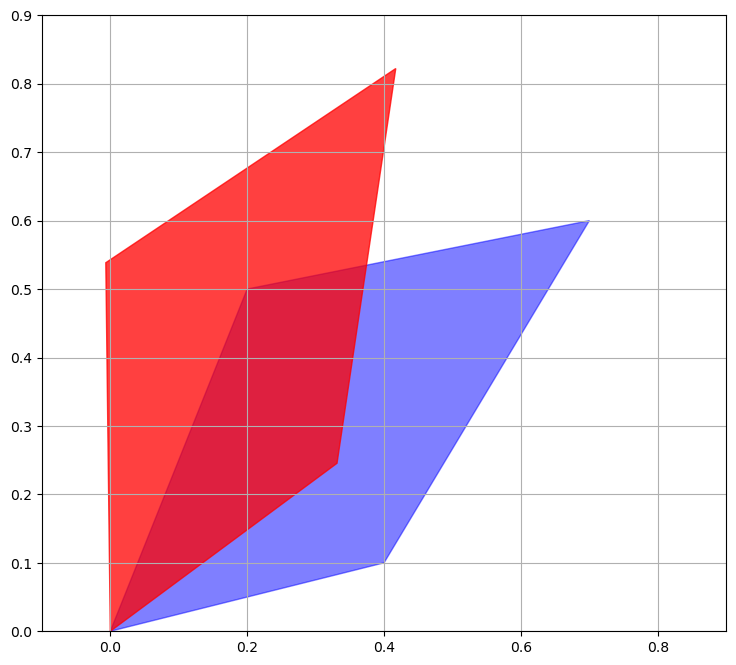

In [47]:
# rotate 22.5 degress or pi/8 radians
theta = np.pi / 8.0 
rotation_factors = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]])

# perform rotation
news = rotation_factors @ s
print(news)
print(news.shape)

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(-0.1, 0.9)
ax.set_ylim(0, 0.9)

# visualize the translation
# plot filled shape, row 0 are x positions and row 1
# are y positions
plt.fill(s[0], s[1], color='blue', alpha=0.5)
plt.fill(news[0], news[1], color='red', alpha=0.75)
plt.grid();

Scaling can be performed using a diagnol matrix defining the vertical and horizontal scaling factors.  
A negative scaling incidentally will cause a flip along the indicated axis.

So to make width 1.5 as big, and to make height 0.5 as big and flip along the
y axis, do:

(2, 2)
(2, 5)
[[ 0.    0.6   1.05  0.3   0.  ]
 [ 0.   -0.05 -0.3  -0.25  0.  ]]
(2, 5)


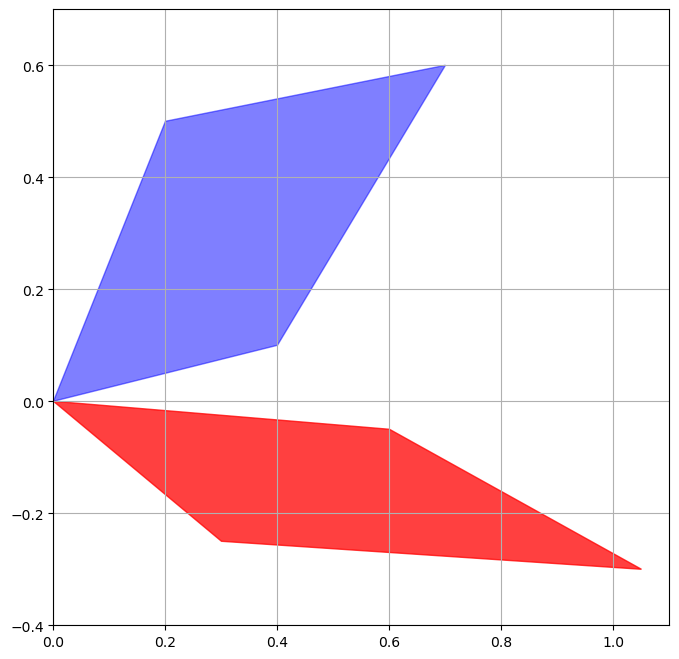

In [48]:
# scale width to be 1.5 times as big, but make 1/2 height and flip
# the y axis
scaling_factors = np.array([
    [1.5,  0.0],
    [0.0, -0.5]])

# perform rotation
print(scaling_factors.shape)
print(s.shape)
news = scaling_factors @ s
print(news)
print(news.shape)

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(0, 1.1)
ax.set_ylim(-0.4, 0.7)

# visualize the scaling operation
# plot filled shape, row 0 are x positions and row 1
# are y positions
plt.fill(s[0], s[1], color='blue', alpha=0.5)
plt.fill(news[0], news[1], color='red', alpha=0.75)
plt.grid();

*Scaling* and *rotation* are both linear transformations.  A dot product with an arbitray matrix implements
a linear transform.

**Affine transform** is a combination of a linear transform (using a dot product with some matrix, and
a translation (achieved by vector addition).  This is the basic calculation used to calculate
the output `y` of a layer from some input `x`, e.g. `y = W @ x + b`

As an example, define `W` as the same scaling operation as above, then translate 0.5 horizontally and
0.2 vertically.

(2, 2)
(2, 5)
[[ 0.5   1.1   1.55  0.8   0.5 ]
 [ 0.2   0.15 -0.1  -0.05  0.2 ]]
(2, 5)


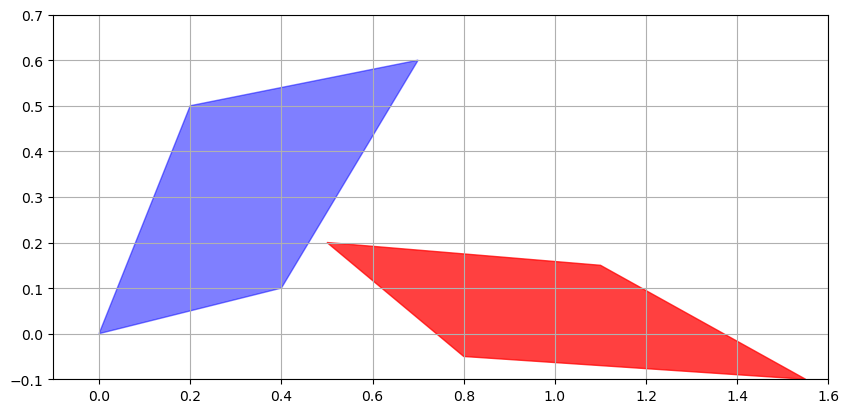

In [49]:
# Same scaling operation as before
W = np.array([
    [1.5,  0.0],
    [0.0, -0.5]])

# the bias here performs a translation, 0.5 vertical and 0.2 horizontal
b = np.array([0.5, 0.2]).reshape(2,1)

# perform rotation
print(W.shape)
print(s.shape)
news = (W @ s) + b
print(news)
print(news.shape)

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(-0.1, 1.6)
ax.set_ylim(-0.1, 0.7)

# visualize the scaling operation
# plot filled shape, column 0 are x positions and column 1
# are y positions
plt.fill(s[0], s[1], color='blue', alpha=0.5)
plt.fill(news[0], news[1], color='red', alpha=0.75)
plt.grid();

Finally lets apply a `relu()` activation.  As discussed in the text, if all you apply are affine transforms
repeatedly, you still end up with an affine transform.  So you could calculate an expression that
applies all serial affine transformations as a single affine transformation.  

In practical terms, this means a dense neural network that only performs affine transformations (linear
transforms and translations) can be reduced to an equivalent single Dense layer.  In that case a
neural network would be equivalent to a linear model in disguise.

However, to allow for nonlinear transformations, neural networks usually apply a nonlinear
activation function to the affine transformation of each layer.  Thanks to the activation
function, a chain of Dense layers can be made to implement very complex non-linear
geometric transformations.  

It may not be obvious, but `relu()` applies a nonlinear activation function.

[[0.5  1.1  1.55 0.8  0.5 ]
 [0.2  0.15 0.   0.   0.2 ]]
(2, 5)


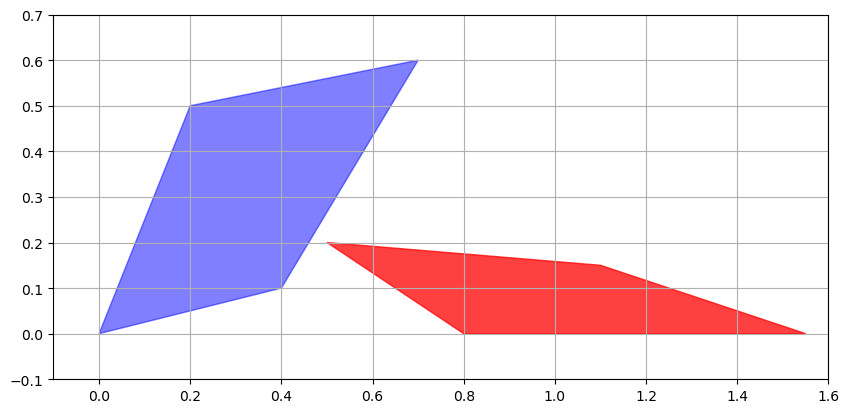

In [50]:
# Same scaling operation as before
W = np.array([
    [1.5,  0.0],
    [0.0, -0.5]])

# the bias here performs a translation, 0.5 vertical and 0.2 horizontal
b = np.array([0.5, 0.2]).reshape(2, 1)

# perform weighted summation and addition of bias, then apply
# a nonlinear relu.  Again the maximum of 0 essentially is the simple
# relu function
news = np.maximum((W @ s) + b, 0.0)
print(news)
print(news.shape)

# set up figure properties
ax = plt.axes()
ax.set_aspect('equal')
ax.set_xlim(-0.1, 1.6)
ax.set_ylim(-0.1, 0.7)

# visualize the scaling operation
# plot filled shape, column 0 are x positions and column 1
# are y positions
plt.fill(s[0], s[1], color='blue', alpha=0.5)
plt.fill(news[0], news[1], color='red', alpha=0.75)
plt.grid();

## 2.3.6 Geometric Interpretation of Deep Learning

A neural network consists of a chain of tensor operations.  Translation, rotation and scaling are are linear transformations, which have
relatively simple geometric interpretations.  In addition neural network apply nonlinear activation functions, which add in ability
to model nonlinear functional relations between the input data and output label to be learned by the network.

